In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
# mnist dataset (60000 train, 10000 test)
# raw dataset
train_data = pd.read_csv("mnist_train.csv")
test_data = pd.read_csv("mnist_test (2).csv")

X_train = train_data.drop(["label"], axis = 1).values
X_test = test_data.drop(["label"], axis = 1).values

y_train = train_data.label.values
y_test = test_data.label.values

print("X Train Shape :", X_train.shape)
print("X Test Shape ", X_test.shape)
print("y Train Shape :",y_train.shape)
print("y Test Shape ",y_test.shape)

# pca (196 features)
pca_train = pd.read_csv('x_train_pca.csv')
pca_test = pd.read_csv('x_test_pca.csv')

# rbm (196 features)
rbm_train = pd.read_csv('x_train_rbm.csv')
rbm_test = pd.read_csv('x_test_rbm.csv')


X Train Shape : (60000, 784)
X Test Shape  (10000, 784)
y Train Shape : (60000,)
y Test Shape  (10000,)


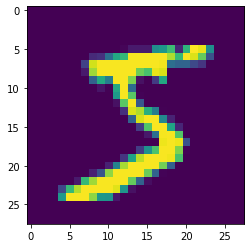

In [3]:
plt.imshow(X_train[0].reshape(28,28))
plt.show()

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model

In [11]:
(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
x_val = x_train[-2000:,:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:,:]
y_train = y_train[:-2000]

In [12]:
x_train.shape

TensorShape([58000, 32, 32, 3])

In [6]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
    path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same',    activation='relu')(x)
    path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)
    path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)
    path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)
    return tf.concat([path1, path2, path3, path4], axis=3)

In [7]:
inp = layers.Input(shape=(32, 32, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inp)
x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)
x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool=32)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool=64)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool=64)
aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)
x = inception(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2) 
aux2 = layers.Dense(10, activation='softmax')(aux2)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = inception(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(10, activation='softmax')(x)

In [8]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [10]:
model.compile(optimizer='adam', 
              loss=[losses.sparse_categorical_crossentropy,
                    losses.sparse_categorical_crossentropy,
                    losses.sparse_categorical_crossentropy]
              ,loss_weights=[1, 0.3, 0.3],
              metrics=['accuracy'])
history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), batch_size=64, epochs=10)

Epoch 1/10
907/907 [==============================] - 2366s 3s/step - loss: 0.7368 - dense_4_loss: 0.5621 - dense_1_loss: 0.2449 - dense_3_loss: 0.3373 - dense_4_accuracy: 0.8170 - dense_1_accuracy: 0.9236 - dense_3_accuracy: 0.8923 - val_loss: 0.1146 - val_dense_4_loss: 0.0786 - val_dense_1_loss: 0.0545 - val_dense_3_loss: 0.0657 - val_dense_4_accuracy: 0.9760 - val_dense_1_accuracy: 0.9855 - val_dense_3_accuracy: 0.9825
Epoch 2/10
907/907 [==============================] - 2384s 3s/step - loss: 0.2027 - dense_4_loss: 0.1409 - dense_1_loss: 0.0965 - dense_3_loss: 0.1094 - dense_4_accuracy: 0.9581 - dense_1_accuracy: 0.9704 - dense_3_accuracy: 0.9665 - val_loss: 0.1320 - val_dense_4_loss: 0.0985 - val_dense_1_loss: 0.0522 - val_dense_3_loss: 0.0595 - val_dense_4_accuracy: 0.9710 - val_dense_1_accuracy: 0.9880 - val_dense_3_accuracy: 0.9835
Epoch 3/10
907/907 [==============================] - 2391s 3s/step - loss: 0.1399 - dense_4_loss: 0.0917 - dense_1_loss: 0.0768 - dense_3_loss: 0.0

In [207]:
#from scipy.misc import imread, imresize
class GoogleNet:
    def __init__(self,input,last):
        self.define_model(input, last)
        self.input = input
        self.last = last
        
    
    def define_model(input,last,weight_path = None):
        #self.input = Input()

        self.conv1_7x7_s2 = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=l2(0.01),input_shape=input)

        self.maxpool1_3x3_s2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv1_7x7_s2)

        self.conv2_3x3_reduce = Conv2D(filters=64, kernel_size=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.01))(maxpool1_3x3_s2)

        self.conv2_3x3 = Conv2D(filters=192, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(conv2_3x3_reduce)

        self.maxpool2_3x3_s2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv2_3x3)

        self.inception_3a = inception_model(input=maxpool2_3x3_s2, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32)

        self.inception_3b = inception_model(input=inception_3a, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64)

        self.maxpool3_3x3_s2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(inception_3b)

        self.inception_4a = inception_model(input=maxpool3_3x3_s2, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64)

        self.inception_4b = inception_model(input=inception_4a, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)

        self.inception_4c = inception_model(input=inception_4b, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)

        self.inception_4d = inception_model(input=inception_4c, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool_proj=64)

        self.inception_4e = inception_model(input=inception_4d, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128)

        self.maxpool4_3x3_s2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(inception_4e)

        self.inception_5a = inception_model(input=maxpool4_3x3_s2, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128)

        self.inception_5b = inception_model(input=inception_5a, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool_proj=128)

        self.averagepool1_7x7_s1 = AveragePooling2D(pool_size=(7, 7), strides=(7, 7), padding='same')(inception_5b)

        self.drop1 = Dropout(rate=0.4)(averagepool1_7x7_s1)

        self.linear = Dense(units=10, activation='softmax', kernel_regularizer=l2(0.01))(keras.layers.core.Flatten()(drop1))
        self.last = linear


        model = Model(inputs=input, outputs=last)
        model.compile(optimizer=Adam(lr=0.0005),loss= 'parse_categorical_crossentropy',metrics=['accuracy'])
        model.fit(input, last)
           #model.summary()
        return model

if __name__ == '__main__':
    Model = GoogleNet(input_shape=X_train,last=y_train)

TypeError: __init__() got an unexpected keyword argument 'input_shape'

In [179]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(Model(28,28,1),show_shapes=True).create(prog='dot',format='svg'))

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


AttributeError: 'NoneType' object has no attribute 'create'

In [74]:
Model.complie(optimizer='adam',loss= 'parse_categorical_crossentropy',metrics=['accuracy'])
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch=64,epochs=40)

AttributeError: 'Functional' object has no attribute 'complie'

In [219]:
from keras.models import Sequential
class GoogleNet:
    def define_model(input,weight_path = None):
        #input = input
        model = Sequential()
        model.add(Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2),
                         padding='same',activation='relu', 
                kernel_regularizer=l2(0.01),input_shape=input))#(input))
        model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
        model.add(Conv2D(filters=64, kernel_size=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Conv2D(filters=192, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)))
        max2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')
        model.add(max2)
        model.add(inception_model(input=max2, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32)
                )
        
        
        
        
        
        
        
        
        # model = Model(input, output)
        return model

In [220]:
a = GoogleNet.define_model(input = (28,28,3))
a.summary()

TypeError: Inputs to a layer should be tensors. Got: <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001B885BAC700>

In [202]:
layer_names=[layer.name for layer in a.layer]

AttributeError: 'Sequential' object has no attribute 'layer'

https://github.com/dingchenwei/googLeNet